# Introduction to Kepler & TESS Data

The data from the Kepler mission is freely available from the [NASA website]( https://exoplanetarchive.ipac.caltech.edu/). 

Obtaining TESS data is a bit more difficult, but we have provided you with data from Kepler and TESS for a number of exoplanet systems in the directory ```Data```. 

Here you can get familiar with how to plot and analyse the data using an example from Kepler.

## Reading in the data

We will be using the same method of reading data as demonstrated in the notebook ```GettingToKnowPython.ipynb```. First, we load all the libraries we need before we get started.

You will notice that we are loading two libraries we have not seen before ```plotly``` and ```batman```.

Plotly allows the creation of interactive plots and batman will be used later in this notebook for creating models of lightcurves.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import batman

The light curves we have provided are available in the  ```./Data``` directory.

For this example we will use ```KIC006922244.tbl```. Feel free to take a look in the data file by double clicking on it. 

To read in the 3 columns of the file we will use ```np.loadtxt``` skipping the 3 rows of header by using ```skiprows=3```

The ```unpack=True``` option tells python to read the three columns of data from the file into the three separate numpy arrays ```z```, ```t```, ```flux```

In [16]:
z, t, flux = np.loadtxt("Data/KIC006922244.tbl",unpack=True,skiprows=3)

The first column in the data file is read into the NumPy array ```z``` and is not of interest to us, so we ignore it. 

The second column contains the time at which the measurement was taken, measured in units of days since 12:00 on 1st January 2009. 

The third column contains the luminosity of the star as observed by the Kepler spacecraft using funny units. The data in this column can be expressed as 
$$\left(\frac{L(t)-L_*}{L_*}\right)$$
where $L(t)$ is the luminosity measured at time $t$, and $L_*$ is the average luminosity of the star when no transit by a planet is occurring. In other words, the data in this column measures the fractional change in the brightness of the star relative to its average intrinsic brightness.

**Please note that we may use the words "luminosity", "flux" and "brightness" interchangeably when discussing how the measured brightness of a star changes!**

Let's look at what our data looks like by plotting ```t``` against ```flux```.

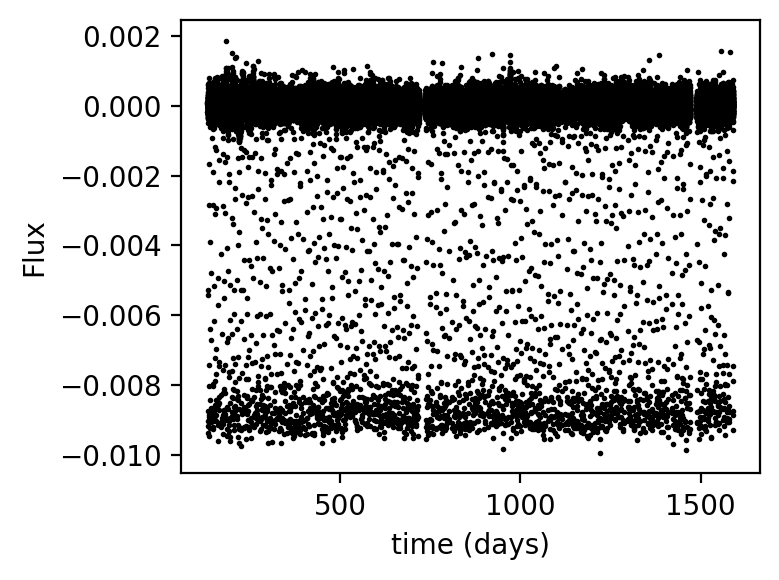

In [17]:
plt.figure(figsize=(4,3))
plt.plot(t,flux,'k.',markersize=2)
plt.xlabel("time (days)")
plt.ylabel("Flux")
plt.tight_layout()

Well, that looks good! We now have a plot of all the luminosity versus time data collected on this object by the Kepler spacecraft. 

The data has been processed using a technique known as detrending, which removes any long term variability caused by changes in the responsiveness of the spacecraft's detector over time. 

The definition of the flux given above also explains why the data is centred around ${\rm Flux}=0$. 

The dips in the lightcurve where Flux goes down to values of approximately -0.01 are the transits due to the planet passing in front of the star. 

## Analysing the transits

Unfortuately, the ```matplotlib``` plotting package does not support interactive plotting when using CoCalc Jupyter notebooks.

Instead, we will use the ```plotly``` package to produce interactive plots that will allow you to inspect the data and analyse the transits.

The following code shows how to use ```plotly``` to generate an interactive plot. Notice the icons at the top right of the figure that allow you to zoom into regions of the plot and pan through the plot.



In [18]:
fig=px.scatter(x=t,y=flux)
fig.update_layout(xaxis_title="Time [days]",yaxis_title="Flux",title="Flux versus time (KIC006922244)")
fig.show()

The dips that can be seen in the above plot showing the data for the system KIC00692244 are the exoplanet transits. 

We can take a closer look by using the zoom tool, which is activated by clicking on the magnifying glass symbol located at the top right of the plot.

Click on the zoom button and then drag your cursor across the plot to define the region you want to zoom into.

Then by hovering your mouse over the data points you can read their coordinates.


## Determining the orbital period of the planet

We now want to estimate the **orbital period** of the planet. This is just the time interval between adjacent transits. 

To estimate the orbital period, use the cursor to determine the times of the midpoints of two neighbouring transits (using the zoom function to do this as accurately as possible). 

The orbital period is the difference between these midpoints. 

We will introduce the concept of phase-folding below. To obtain an accurate phase fold of the data we are going to need an accurate and precise estimate of the orbital period.

By hovering the cursor, ```Plotly``` allows us to obtain the coordinates of the data points in the light curve. 

However, this does not allow us to obtain a precise estimate of the midpoint of a transit if there are no data points there.

The following code cell provides one way to get around this problem. 

It creates a new set of finely-spaced points (called ```xline``` and ```yline```)

The values in ```xline``` run from the beginning of the Kepler data set up until about 3 orbital periods into the data.

The values in ```yline``` set to be near the depth of the transit.

The code cell plots the new data points along with the Kepler data.

We can zoom in and hover the cursor over the new points to get a better estimate of the midpoints of the first few transits.


In [19]:
xstart=t[0] # This is the time corresponding to the first data point in the light curve
period=3.52 # This is a rough estimate of the period obtained from zooming the light curve
depth=0.009 # This is a rough estimate of the depth of the transits
xend=xstart+3.*period # Here we place the final data point at about 3 periods into the light curve
npoints=10000 # Our finely-spaced data set contains this many points
xline=np.linspace(xstart,xend,npoints) # Create a set of x-values running from xstart to xend and containing npoints
yline=np.zeros(npoints)-depth # Create a set of y-values that sit near the base of the transits

fig=px.scatter(x=t,y=flux) # Plot the light curve
fig.add_scatter(x=xline,y=yline,mode='markers') # Plot the finely-spaced points
fig.show()

## Phase folding
We have now read the data, plotted it and have estimated the orbital period. 

You will have seen that the number of data points contained in each transit is small, because the Kepler spacecraft only recorded data every 30 minutes. A typical transit lasts for a few hours, so the data coverage of an individual transit is very sparse - approximately 8 points per transit.

To get a smooth lightcurve that we can use to determine the properties of a planet we need to perform an operation called phase folding. 

Phase folding is an operation where periodic data is folded over on itself at the right interval (i.e. the period), so that we end up with what looks like a single transit with the gaps filled in by the data points.

This is done with a modulo operation on the $t$ coordinate,
\begin{equation}
t\rightarrow t \: \mathrm{mod} \: P
\end{equation}
where $P$ is the period of the data. 

Before we phase fold the Kepler data, let's test this idea by generating some very sparse periodic data that mimics a Kepler light curve then phase fold it. 

Don't worry about trying to understand the code that generates the synthetic data!

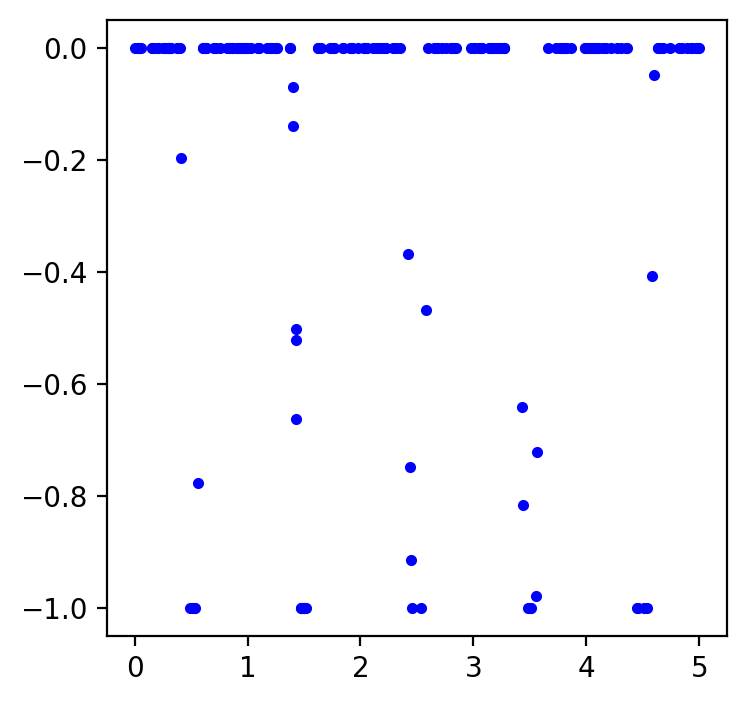

In [28]:
# Here we generate 200 random data points
# that mimic how a transit light curve might look
# We store the time data in an array t2 and
# the flux data in an array y.
ndata=200
t2=np.sort(5.*np.random.rand(ndata))
y=np.zeros(ndata,dtype=float)
gradient=-20.
for i in range (0,ndata):
    if (t2[i]%1.0>=0.4) and (t2[i]%1 <=0.45):
        y[i]=0.+gradient*(t2[i]%1-0.4)
    elif (t2[i]%1.0>=0.55) and (t2[i]%1 <=0.60):
        y[i]=0.+gradient*(0.6-t2[i]%1)
    elif (t2[i]%1.0>0.45) and (t2[i]%1 <=0.55):
        y[i]=-1.
    else:
        y[i]=0.
plt.figure(figsize=(4,4))
plt.plot(t2,y,'b.')

As you can see, the sparse data is difficult to identify as a periodic signal. Let's replot it and draw a dotted line to guide the eye. 

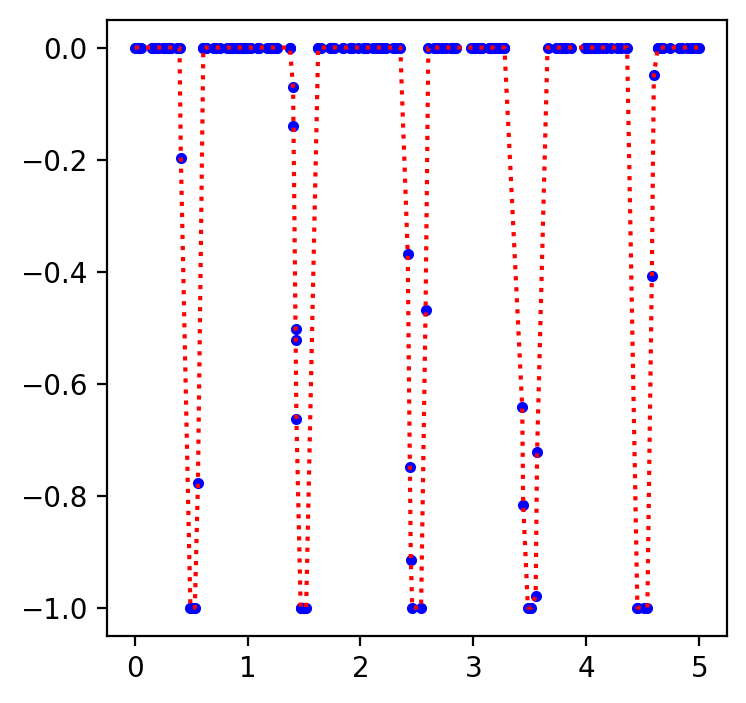

In [29]:
plt.figure(figsize=(4,4))
plt.plot(t2,y,'b.')
plt.plot(t2,y,'r:')

Now we can see the data looks to be periodic. By-eye inspection suggests the y-values vary between 0.0 and -1.0 with the minima being centred on the values t=0.5, 1.5, 2.5, 3.5,... 

Hence, it appears that the period $P=1.0$. 

Let's use the python modulo operator to phase fold the data and then plot $t\: \mathrm{mod} \: P $ against $y$.

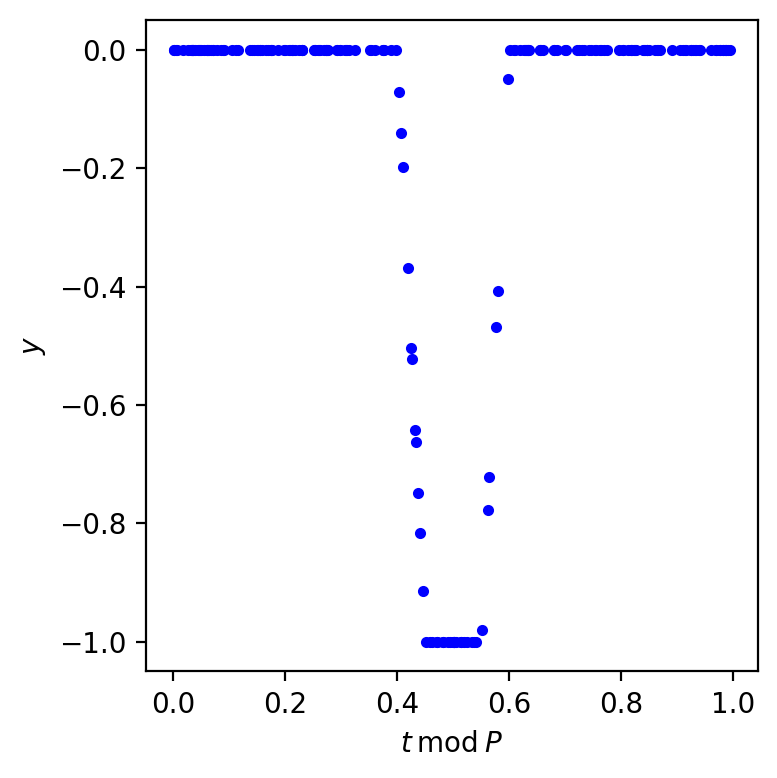

In [30]:
P=1.0
tPhaseFolded=t2%P

plt.figure(figsize=(4,4))
plt.plot(tPhaseFolded,y,'b.')
plt.xlabel("$t\:\mathrm{mod}\: P$")
plt.ylabel("$y$")
plt.tight_layout()
plt.show()

**That looks better!** Now we can easily see the shape of the synthetic light curve.

Sometimes, though, we do not know the exact period, and a small error in the period can lead to funny looking phase folded data so.

If you get a fuzzy looking line try changing your period estimate up and down by small amounts. 

This can be tedious and a bit annoying, but when you get a good enough period estimate all the points will align nicely and a clean transit signal will emerge. 

In the cell below I shift the period estimate towards and away from the correct period so you can see what this looks like.

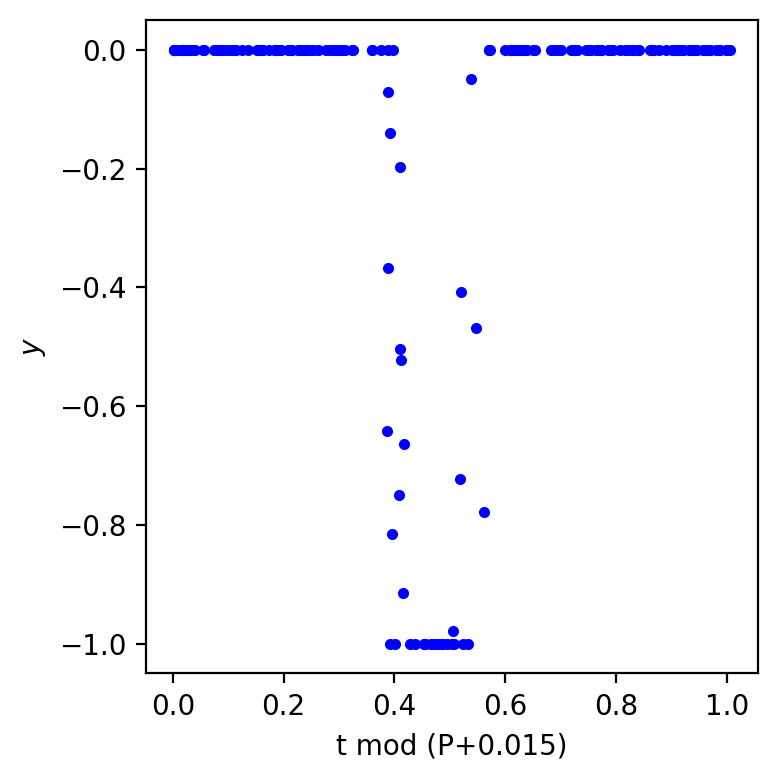

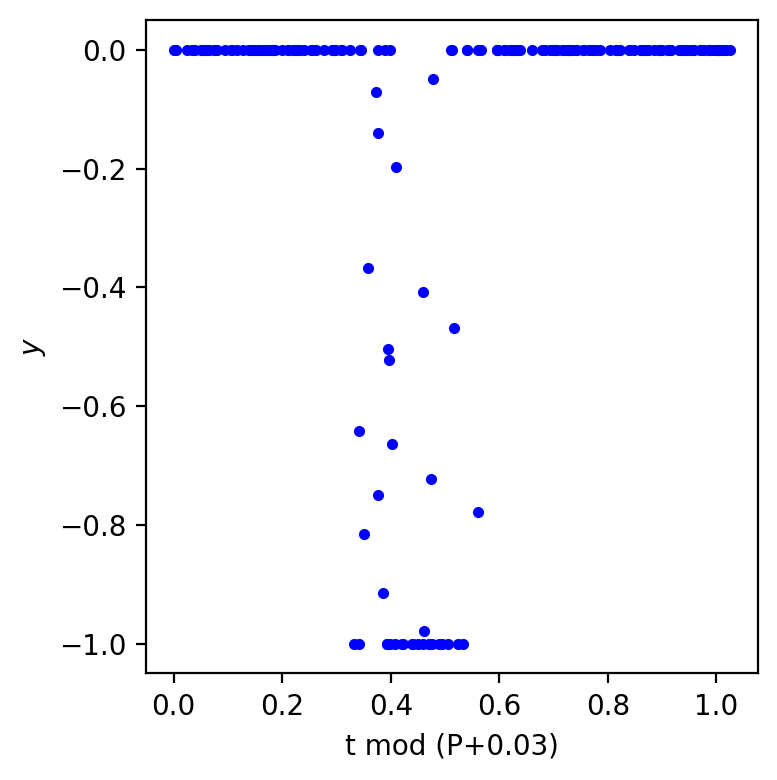

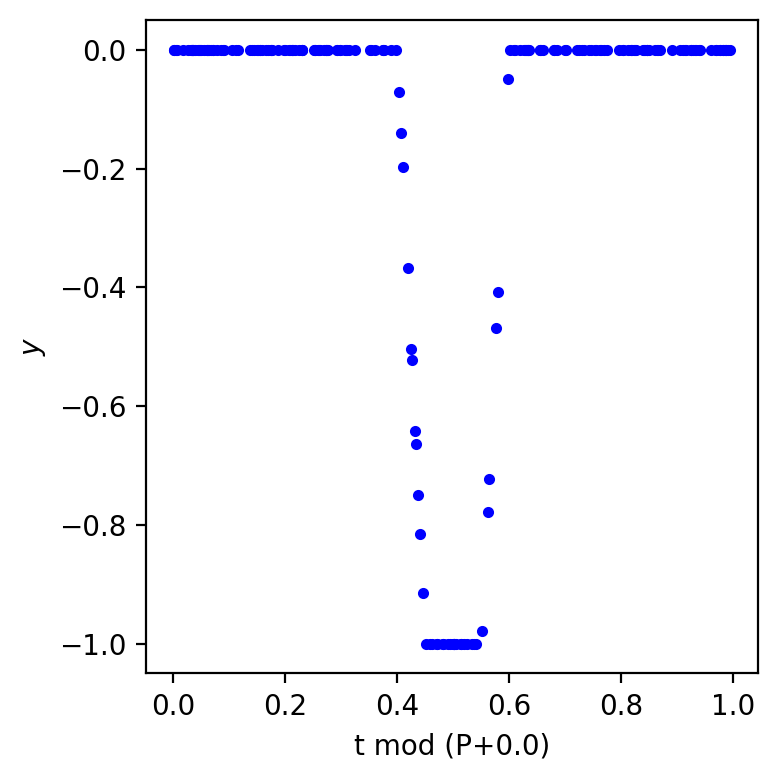

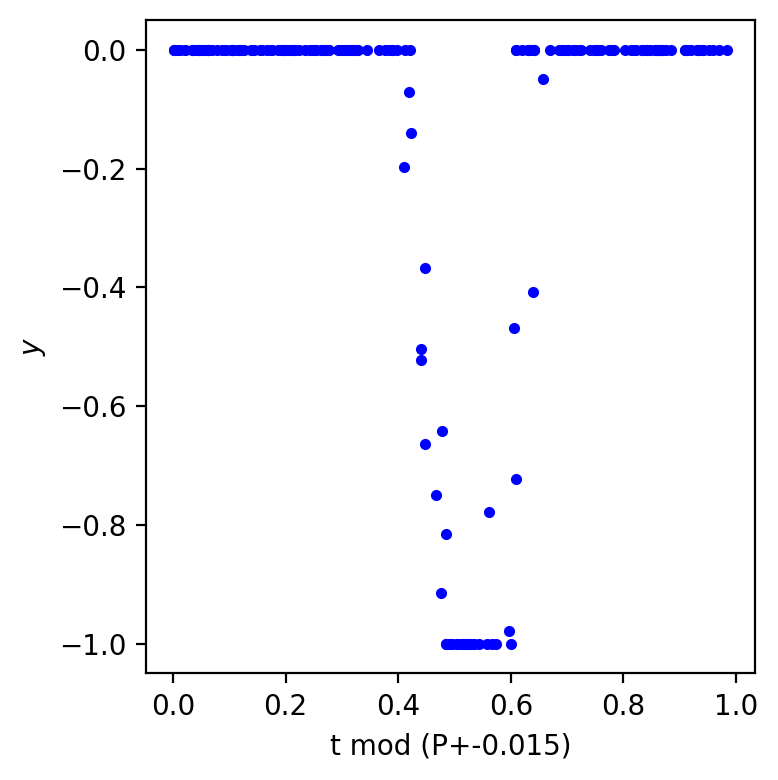

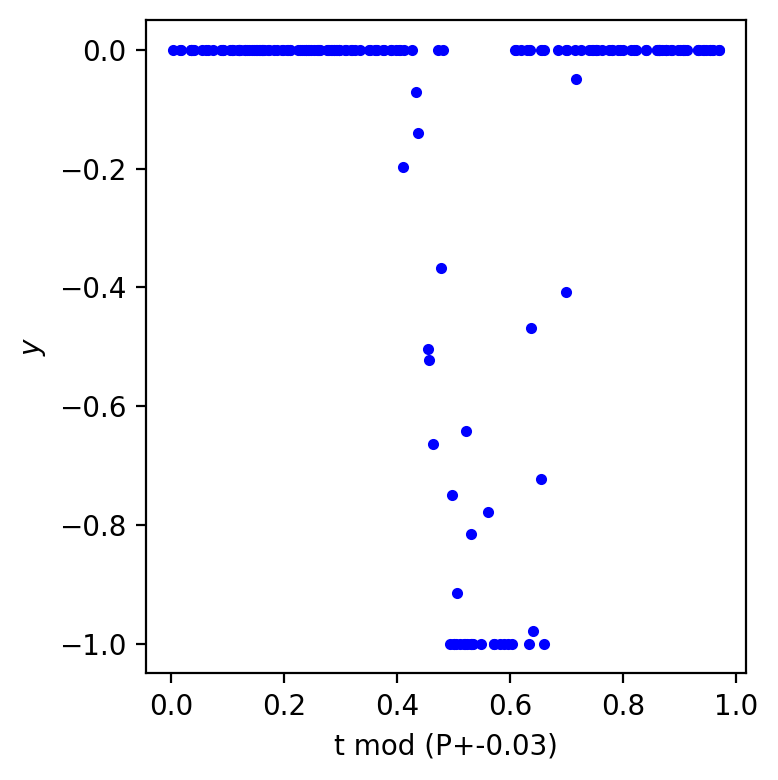

In [31]:
# Executing this cell will output several plots
for i in [0.015,0.03,0.0,-0.015,-0.03]:
    tPhaseFolded=t2%(P+i)

    plt.figure(figsize=(4,4))
    plt.plot(tPhaseFolded,y,'b.')
    xstring="t mod (P+"+str(i)+")"
    plt.xlabel(xstring)
    plt.ylabel("$y$")
    plt.tight_layout()
    plt.show()

Clearly only one of the above plots shows a nice phase folded lightcurve! 

**Be aware of the need to obtain an accurate estimate of the orbital period of the planet when you are analysing transit light curves and phase folding them!**

### Centering the transit
Once you have managed to get a good phase fold we will need to center our transit at t=0.0 with 0.0 in the middle of our plot. Doing this will make the data esier to read and analyse.

Let's look at our example again, and say we want to move the minimum to 0 in the centre of our plot. 

By-eye inspection tells us that once we have phase folded we need to subtract P/2 from the values along the x-axis.

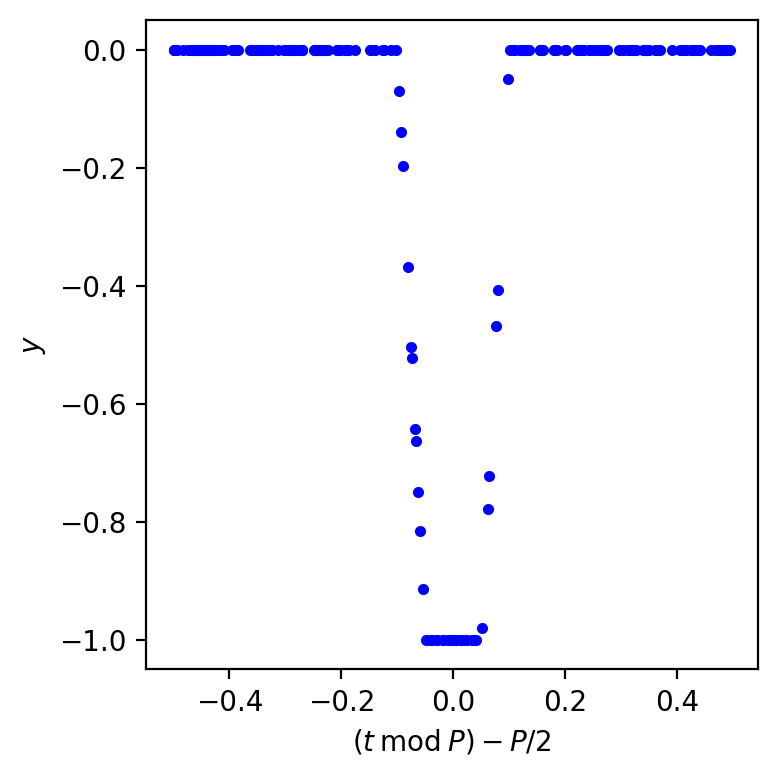

In [41]:
tPhaseFolded=(t2%P)-P/2. # subtract or add to X to move your function along the x axis
plt.figure(figsize=(4,4))
plt.plot(tPhaseFolded,y,'b.')
plt.xlabel("$(t\:\mathrm{mod}\: P) - P/2.$")
plt.ylabel("$y$")
plt.tight_layout()
plt.show()

I have already phase folded KIC006922244 so you can have an idea what the finished product will more or less look like. The data is in the file ```Data/KIC006922244_phaseFold.dat```. 

Here it is plotted: 

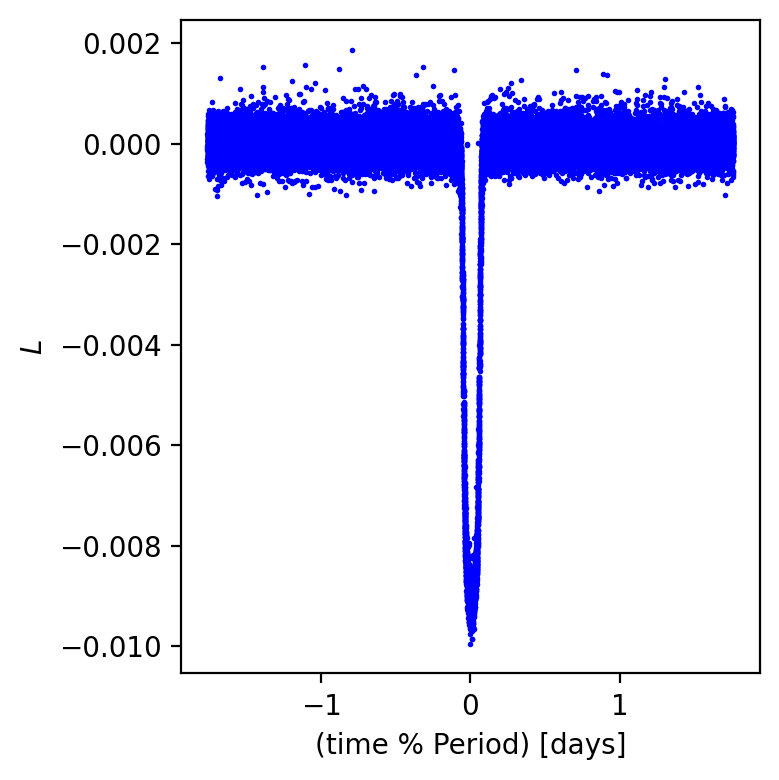

In [33]:
t_pf, flux2 = np.loadtxt("Data/KIC006922244_phaseFold.dat",unpack=True)
plt.figure(figsize=(4,4))
plt.plot(t_pf,flux2,'b.',markersize=2)
plt.xlabel("(time % Period) [days]")
plt.ylabel("$L$")
plt.tight_layout()
plt.show()

The period I used for this phase fold was ```P=3.522X``` where ```X``` is the final digit in the number corresponding to the period. Try to find the period yourselves by phase folding the data and trying different values of ```X```. This will give you a feel for how sensitive the phase fold is to the period estimate. Note that in general the period estimate needs to be accurate to the 4th decimal digit for the best phase folded lightcurve to be obtained.

## What next?

Now that you have taken the first steps in analysing a light curve what can you do next? 

### 1. Find planetary system parameters using model fitting

We can use a Python package called ```batman``` to create a model of the phase folded light curve.

Note that we imported this package at the top of this notebook and you must do this in any notebook that uses ```batman```

To find out more about `batman` click this link: [Batman](https://lkreidberg.github.io/batman/docs/html/index.html "Batman hyperlink")

We can change the parameters of the model so that it gives a good fit to the data.

By doing this, we can try to obtain accurate parameters for the planet and its orbit around the star.

These include: 
1. Planetary radius
2. Orbital period
3. Semimajor axis
4. Orbital inclination

To find out what these parameters mean, please look at the notebook called **ObtainingPlanetParameters** we have provided.

In particular, this explains what we mean by semimajor axis and orbital inclination and also gives the equation you need to calculate the semimajor axis.

Below, I have used ```batman``` to create a model of the data and I have overplotted the model on the phase folded light curve.

To undertake a complete ste-by-step analysis of the KIC006922244 data set, please follow the steps given in the **KeplerGuidedExercises** notebook we have provided. 

This leads you through a systematic exploration of the KIC006922244 data using everything you have learned from this notebook.

### 2. Explore more light curves

In the Data directory, you will find many more light curves, try to find more planets and determine their system parameters!

### 3. Get creative

You can take your independent research in any direction you want, but below are some suggestions. If you manage to complete the analysis of the Kepler and TESS data we have provided and you wish to look at some other systems please let us know and we can provide you with lots more data!

1. Extend your search to more Kepler data and even into TESS data (some is already provided in files ```./Data/TIC...```"TIC" mean "TESS Input Catalogue")
2. Automate your search, write code to automatically determine the planet parameters from a light curve
3. Try finding planet parameters for all the planets in a multiplanet system.



### Example of using batman to create a model which is overplotted on the phase folded light curve
Below you can see the quality of the fit provided by the model. Use this code as an example how to generate a model.

Please note the model produces a flux=1 when out of transit. We therefore need to plot ```fluxmodel```-1 to compare it with the data.

In [38]:
params = batman.TransitParams()
params.t0 = 0.0                      #time of inferior conjunction - this is time at which phase folded light curve is centred
params.per = 3.5225                  #orbital period
params.rp = 0.092                    #planet radius (in units of stellar radii)
params.a = 7.54                      #semi-major axis (in units of stellar radii)
params.inc = 85.2                    #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity - don't change this
params.w = 90.                       #longitude of periastron (in degrees) - don't change this
params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2] - don't change these
params.limb_dark = "quadratic"       #limb darkening model - don't change this

In [39]:
tmodel=np.linspace(-1.5,1.5,200)        # Create 200 data points that will act as the time coordinate for the model
m = batman.TransitModel(params, tmodel) # Initialize the model
fluxmodel = m.light_curve(params)       # Create the model light curve

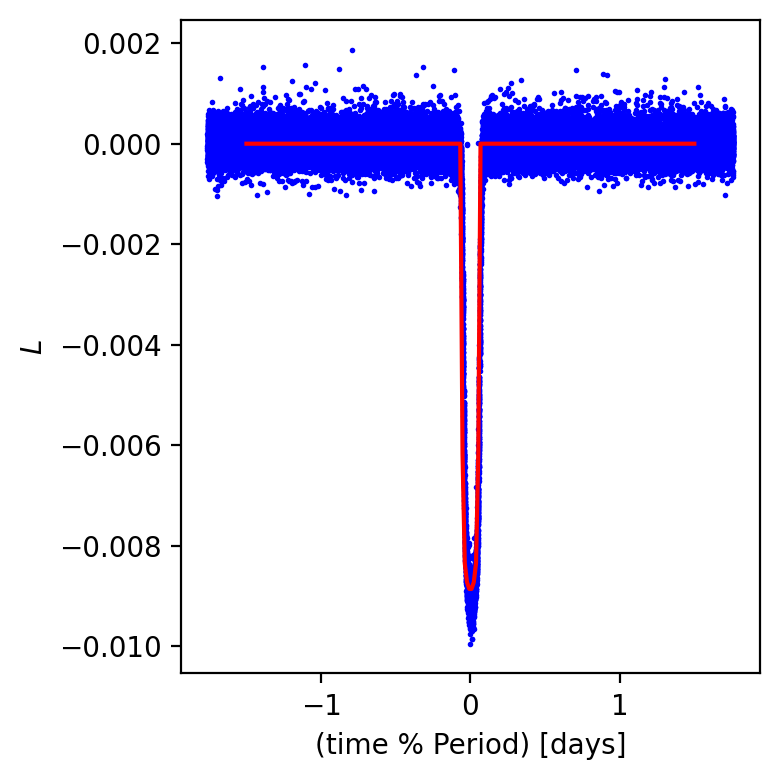

In [40]:
t_pf, flux2 = np.loadtxt("Data/KIC006922244_phaseFold.dat",unpack=True)
plt.figure(figsize=(4,4))
plt.plot(t_pf,flux2,'b.',markersize=2)    # Plot the phasefolded data
plt.plot(tmodel,fluxmodel-1.,'r-')        # Plot the model
plt.xlabel("(time % Period) [days]")
plt.ylabel("$L$")
plt.tight_layout()
plt.show()